In [1]:
# Use this to add the tag_tracking folder to python path for imports
import os, sys
tag_tracking_path = os.path.abspath(os.path.join('', './../..'))
sys.path.insert(0, tag_tracking_path)

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch_track.network_resnet2 import ResNet2
from torch_track.utils_anim import Animate_FullIm
from tagsim.utils import get_patch_path

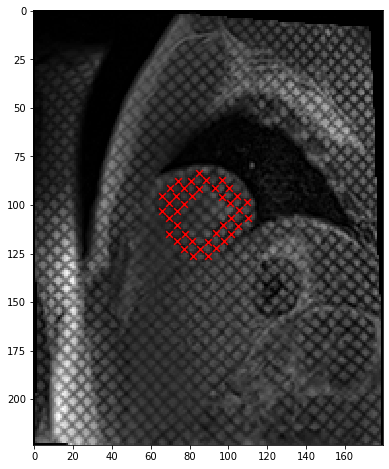

In [2]:
# Load the sample dataset
npz = np.load('../sample_data/in_vivo_data.npz')
imt = npz['imt']
r0 = npz['r0']

# Plot the points we are tracking
plt.figure(figsize=(8,8))
plt.imshow(imt[0], cmap='gray')
plt.scatter(r0[:,0], r0[:,1], 45, c='r', marker='x')

In [3]:
# Get patches for each point in r0

N = r0.shape[0]
X = np.empty((N, 1, 25, 32, 32), np.float32)

for i in range(N):
    track_init = r0[i]
    im_p, tag_p = get_patch_path(imt, track_init, is_scaled = True)
    X[i] = im_p.copy()
    
# Normalize patches
for i in range(X.shape[0]):
    im = X[i]
    im = (im-im.mean()) / im.std()
    X[i] = im

In [4]:
# Load the model
# ----------------

# device = torch.device("cuda:0") # For GPU inference
device = torch.device("cpu") # For CPU inference

state_name = '../network_saves/resnet2_grid_tracking.pt'

kwargs = {}
kwargs['do_coordconv'] = True
kwargs['fc_shortcut'] = False
# kwargs['init_width'] = 128

model = ResNet2([2, 2, 2, 2], **kwargs)

# state = torch.load('./resnet2_18_big_k2_batch16_bestref.pt', map_location='cpu')
state = torch.load(state_name, map_location=device)

model.load_state_dict(state)

model = model.to(device)

In [5]:
batch_size = 8

y1 = []
N = X.shape[0]
N_batches = int(np.ceil(N / batch_size))

print('Running: batch = ', end = '', flush = True)
with torch.no_grad():  
    for i in range(N_batches):
        print(i, end = ' ', flush=True)
        x = X[i*batch_size:(i+1)*batch_size]
        x = torch.from_numpy(x).to(device)
        y_pred = model(x)
        y1.append(y_pred.detach().cpu().numpy())

y1 = np.vstack(y1)
y1 = y1.reshape([y1.shape[0], 2, 25])
print('Done!')

# y1 is the paths relative to the center of the patches, add r0 to get in image coords
y1r = y1 + r0[:,:,None]

Running: batch = 0 1 2 3 4 5 Done!


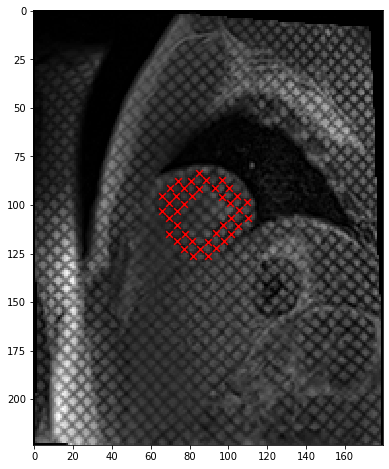

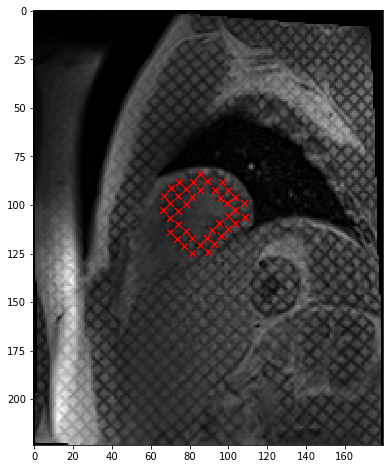

In [6]:
# Plot the points at time 0 and 12
i_t = 0
plt.figure(figsize=(8,8))
plt.imshow(imt[i_t], cmap='gray')
plt.scatter(y1r[:,0,i_t], y1r[:,1,i_t], 45, c='r', marker='x')

i_t = 12
plt.figure(figsize=(8,8))
plt.imshow(imt[i_t], cmap='gray')
plt.scatter(y1r[:,0,i_t], y1r[:,1,i_t], 45, c='r', marker='x')

In [7]:
# This makes an animation og the tracking within the jupyter notebook

from IPython.display import HTML
from matplotlib import animation, rc

A = Animate_FullIm(imt, y1r)
HTML(A.anim.to_jshtml())

Starting animation class . . . 
Making animation . . . 
